In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=800)


# what's the use of Typing package and TypeDict class

In [2]:
from typing_extensions import TypedDict

class Person(TypedDict):
    name: str
    age: int

def greet(person: Person) -> str:
    return f"Hello {person['name']}, age {person['age']}"


joker = Person(name="joker",age=45)
print(greet(joker))  

Hello joker, age 45


In [3]:
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wiki_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [4]:
wiki_tool.invoke("Who is david warners")

"Page: David Warner (actor)\nSummary: David Hattersley Warner (29 July 1940 – 24 July 2022) was an English actor who worked in film, television and theatre. Warner's lanky, often haggard appearance lent itself to a variety of villainous characters as well as more sympathetic roles across stage and screen. He received accolades such as a Primetime Emmy Award and nominations for a BAFTA Award and Screen Actors Guild Award.\nWarner trained at the Royal Academy of Dramatic Art before joining the Royal Shakespeare Company (RSC) where he made his stage debut in 1962 where he played Henry VI in The Wars of the Roses cycle at the West End's Aldwych Theatre in 1964. The RSC then cast him as Prince Hamlet in Peter Hall's 1965 production of Hamlet. He made his Broadway debut in the 2001 revival of Major"

In [5]:
arxiv_tool.invoke("What is multi head masked attention")

'Published: 2023-03-24\nTitle: How Does Attention Work in Vision Transformers? A Visual Analytics Attempt\nAuthors: Yiran Li, Junpeng Wang, Xin Dai, Liang Wang, Chin-Chia Michael Yeh, Yan Zheng, Wei Zhang, Kwan-Liu Ma\nSummary: Vision transformer (ViT) expands the success of transformer models from\nsequ'

In [6]:
tools = [arxiv_tool,wiki_tool]

In [7]:
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END

class State(TypedDict):
    messages:Annotated[list,add_messages]
    

In [8]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model='llama-3.2-3b-preview', groq_api_key=groq_api_key)

In [9]:
llm_with_tools = llm.bind_tools(tools=tools)

In [10]:
from langgraph.prebuilt import ToolNode,tools_condition

In [11]:
graph_builder = StateGraph(State)

def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [12]:
# Add nodes again
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", "__end__")

In [13]:
graph = graph_builder.compile()

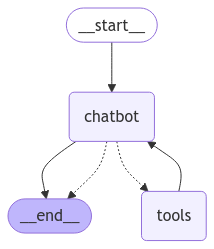

In [14]:
from IPython.display import Markdown,display,Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

# Whenever you encounter a bi-directional edge in the graph , you need to use the Langgraph's add conditional edges 

In [ ]:
while True:
    user_input = input("Enter your prompt: ")

    if user_input in ["quit", "q"]:
        print("Goodbye")
        break

    
    for event in graph.stream({"messages":("user", user_input)}):
        for value in event.values():

         
            if "messages" in value:
                for message in value["messages"]:
                    if "<function=" in message.content or "<wikipedia>" in message.content:
                        print("Assistant: Processing query or function call...")
                    elif message.content.strip() == "":
                        print("Assistant: No response or empty result.")
                    else:
                        print("Assistant:", message.content)  